# Time Series Analysis on Ethereum

In [17]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [18]:
%matplotlib inline

In [19]:
sc

In [20]:
from pyspark.sql import HiveContext

In [21]:
hive_context = HiveContext(sc)

In [22]:
btc_price = hive_context.table("cryptocurrency.ether_price_mod")

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import pandas as pd

In [24]:
btc_price.show()

+----------+------+------+------+------+------------+--------------+
|      date|  open|  high|   low| close|      volume|    market_cap|
+----------+------+------+------+------+------------+--------------+
|2018-04-12|430.16|493.06|417.41|492.94|   2.51936E9|42483600000.00|
|2018-04-11|415.02|430.54|412.47|430.54|   1.43904E9|40980200000.00|
|2018-04-10|399.41|415.89|393.88|414.24|     1.196E9|39430400000.00|
|2018-04-09|400.86|429.25|390.61|398.53|1.47839002E9|39565100000.00|
|2018-04-08|385.74|402.59| 385.6|400.51|   9.48488E8|38065400000.00|
|2018-04-07|370.38|393.06|369.94|385.31| 9.5147501E8|36541900000.00|
|2018-04-06|382.73| 385.2|366.91|370.29| 9.6710598E8|37752600000.00|
|2018-04-05|379.95|387.72|369.82|383.23|1.21068006E9|37470200000.00|
|2018-04-04|416.49|417.47|375.31|380.54|1.28773005E9|41065100000.00|
|2018-04-03|387.31|418.97|383.53|416.89|1.36339994E9|38180800000.00|
|2018-04-02| 379.7|395.17|377.59|386.43|1.10225997E9|37422500000.00|
|2018-04-01|397.25|400.53|363.81|3

### Data Preprocessing

In [59]:
#Converting to Pandas data frame
btc_pdf = btc_price.toPandas()
btc_pdf.head(10)

,date,open,high,low,close,volume,market_cap
0,2018-04-12,430.160004,493.059998,417.410004,492.940002,2.519360e+09,42483600000.00
1,2018-04-11,415.019989,430.540009,412.470001,430.540009,1.439040e+09,40980200000.00
2,2018-04-10,399.410004,415.890015,393.880005,414.239990,1.196000e+09,39430400000.00
3,2018-04-09,400.859985,429.250000,390.609985,398.529999,1.478390e+09,39565100000.00
4,2018-04-08,385.739990,402.589996,385.600006,400.510010,9.484880e+08,38065400000.00
5,2018-04-07,370.380005,393.059998,369.940002,385.309998,9.514750e+08,36541900000.00
6,2018-04-06,382.730011,385.200012,366.910004,370.290009,9.671060e+08,37752600000.00
7,2018-04-05,379.950012,387.720001,369.820007,383.230011,1.210680e+09,37470200000.00
8,2018-04-04,416.489990,417.470001,375.309998,380.540009,1.287730e+09,41065100000.00
9,2018-04-03,387.309998,418.970001,383.529999,416.890015,1.363400e+09,38180800000.00


/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,date,close
0,2015-08-07,2.77
1,2015-08-08,0.75
2,2015-08-09,0.70
3,2015-08-10,0.71
4,2015-08-11,1.07


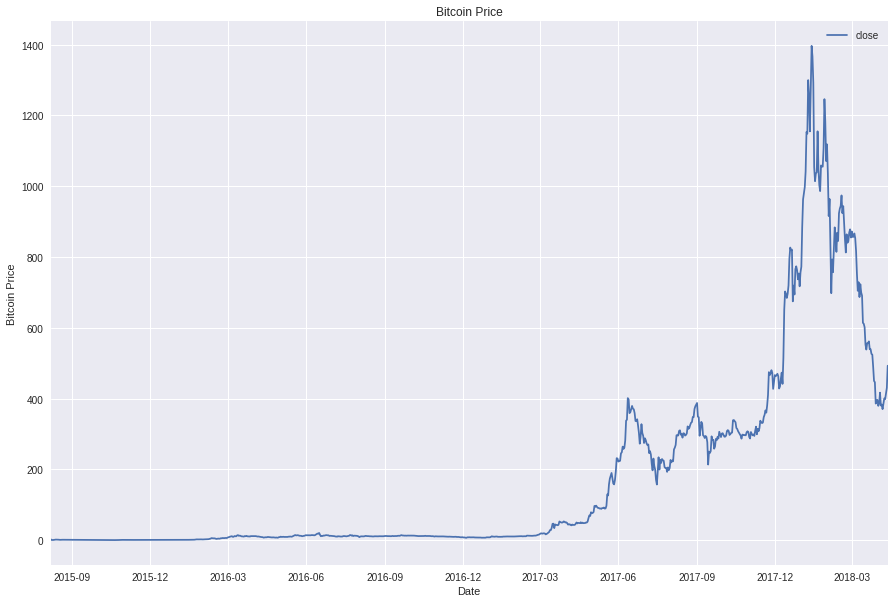

In [60]:
#Bitcoin Closing Price

df = pd.concat([btc_pdf['date'],btc_pdf['close']],axis=1)
df= df.sort('date')
df=df.reset_index(drop=True)

df.head(5)
ax = df.plot(x="date", y="close", kind='line',title='Bitcoin Price',figsize=(15,10))
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.show()

### Check Stationarity

In [27]:
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

In [28]:
df['date'] = pd.to_datetime(df['date'])
print df.dtypes
df =df.set_index('date')
df.head(5)
df.index

date     datetime64[ns]
close           float64
dtype: object


,close
date,
2015-08-07,2.77
2015-08-08,0.75
2015-08-09,0.70
2015-08-10,0.71
2015-08-11,1.07


DatetimeIndex(['2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10',
               '2015-08-11', '2015-08-12', '2015-08-13', '2015-08-14',
               '2015-08-15', '2015-08-16',
               ...
               '2018-04-03', '2018-04-04', '2018-04-05', '2018-04-06',
               '2018-04-07', '2018-04-08', '2018-04-09', '2018-04-10',
               '2018-04-11', '2018-04-12'],
              dtype='datetime64[ns]', name=u'date', length=980, freq=None)

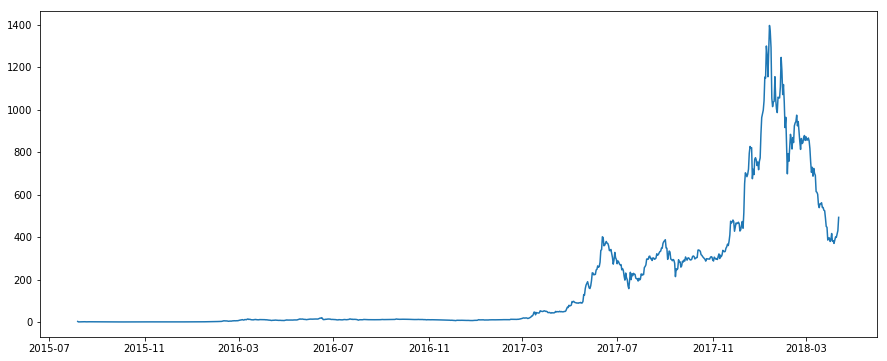

In [29]:
plt.plot(df)

In [30]:
ts = df['close']
mean_ts = np.nanmean(ts, axis=0)
ts[ts== 0] = mean_ts
ts.head(5)

date
2015-08-07    2.77
2015-08-08    0.75
2015-08-09    0.70
2015-08-10    0.71
2015-08-11    1.07
Name: close, dtype: float64

In [31]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


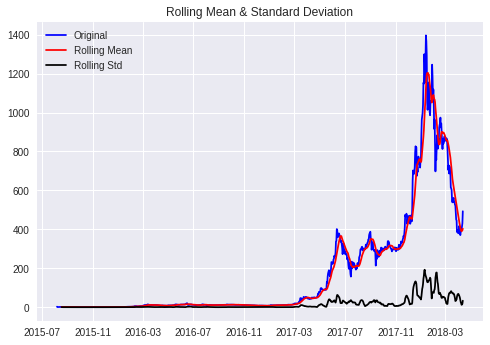

Results of Dickey-Fuller Test:
Test Statistic                  -1.721754
p-value                          0.419940
#Lags Used                      21.000000
Number of Observations Used    958.000000
Critical Value (5%)             -2.864562
Critical Value (1%)             -3.437194
Critical Value (10%)            -2.568379
dtype: float64


In [61]:
test_stationarity(ts)

## Make Time Series Stationary

### Estimating And Eliminating Trends

In [33]:
ts_log = np.log(ts)
from numpy import inf
ts_log[ts_log == -inf] = 0
mean_ts = np.nanmean(ts_log, axis=0)
ts_log[ts_log == 0] = mean_ts
print ts_log

date
2015-08-07    1.018847
2015-08-08   -0.287682
2015-08-09   -0.356675
2015-08-10   -0.342490
2015-08-11    0.067659
2015-08-12    0.198851
2015-08-13    0.604316
2015-08-14    0.604316
2015-08-15    0.524729
2015-08-16    0.451076
2015-08-17    0.182322
2015-08-18    0.086178
2015-08-19    0.231112
2015-08-20    0.378436
2015-08-21    0.336472
2015-08-22    0.322083
2015-08-23    0.300105
2015-08-24    0.207014
2015-08-25    0.131028
2015-08-26    0.148420
2015-08-27    0.139762
2015-08-28    0.173953
2015-08-29    0.165514
2015-08-30    0.277632
2015-08-31    0.307485
2015-09-01    0.300105
2015-09-02    0.254642
2015-09-03    0.231112
2015-09-04    0.239017
2015-09-05    0.292670
                ...   
2018-03-14    6.420467
2018-03-15    6.415588
2018-03-16    6.399709
2018-03-17    6.314960
2018-03-18    6.289047
2018-03-19    6.322080
2018-03-20    6.322888
2018-03-21    6.331021
2018-03-22    6.291013
2018-03-23    6.290865
2018-03-24    6.266137
2018-03-25    6.262045
2018-0

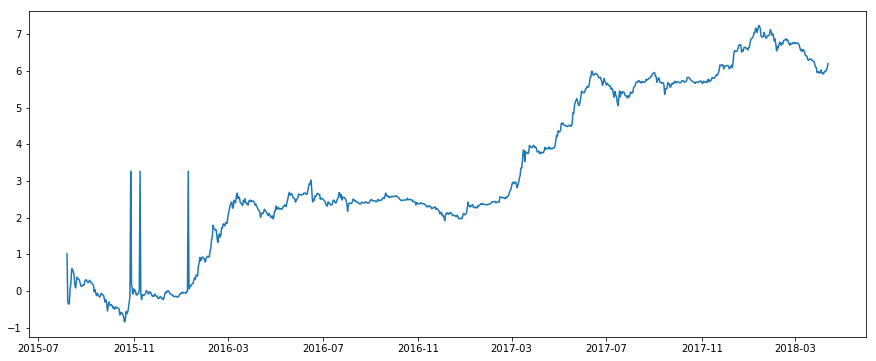

In [34]:
plt.plot(ts_log)

### Moving Average

/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if __name__ == '__main__':


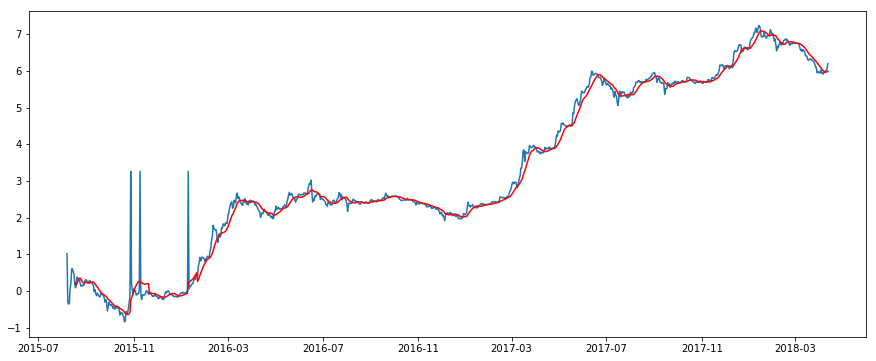

In [35]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [36]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(17)

date
2015-08-07         NaN
2015-08-08         NaN
2015-08-09         NaN
2015-08-10         NaN
2015-08-11         NaN
2015-08-12         NaN
2015-08-13         NaN
2015-08-14         NaN
2015-08-15         NaN
2015-08-16         NaN
2015-08-17         NaN
2015-08-18   -0.143109
2015-08-19    0.067469
2015-08-20    0.159284
2015-08-21    0.059558
2015-08-22   -0.010212
2015-08-23   -0.051562
Name: close, dtype: float64

/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


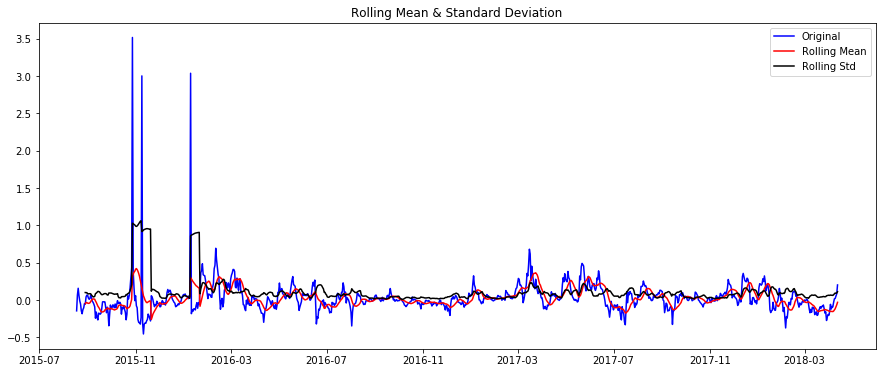

Results of Dickey-Fuller Test:
Test Statistic                -5.913428e+00
p-value                        2.606288e-07
#Lags Used                     1.200000e+01
Number of Observations Used    9.560000e+02
Critical Value (5%)           -2.864568e+00
Critical Value (1%)           -3.437209e+00
Critical Value (10%)          -2.568382e+00
dtype: float64


In [37]:
ts_log_moving_avg_diff.dropna(inplace=True)

test_stationarity(ts_log_moving_avg_diff)

### Exponentially Weighted Average

/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


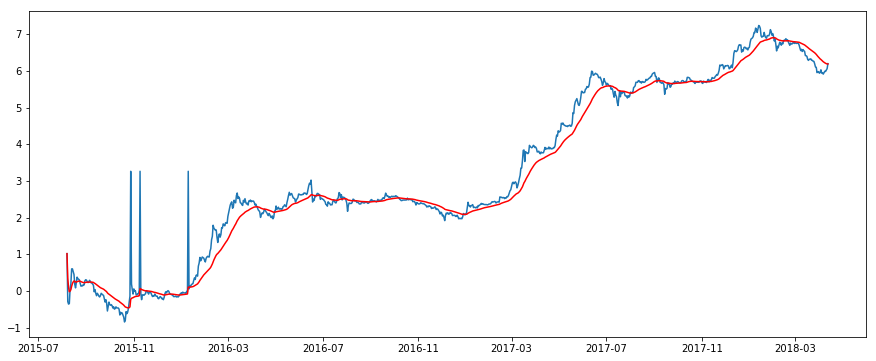

In [38]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


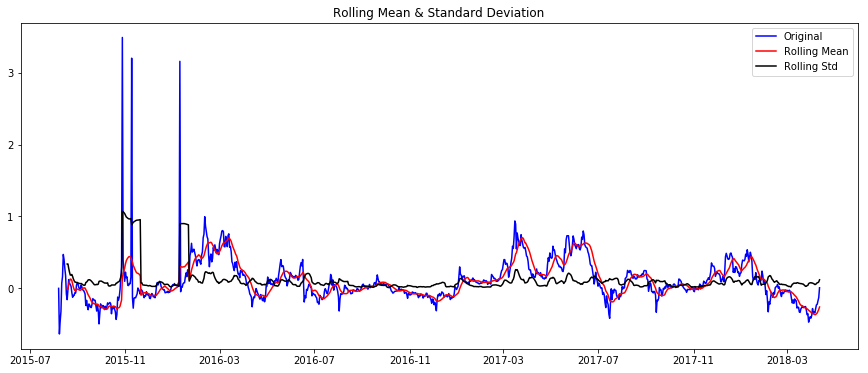

Results of Dickey-Fuller Test:
Test Statistic                  -3.520697
p-value                          0.007471
#Lags Used                      13.000000
Number of Observations Used    966.000000
Critical Value (5%)             -2.864537
Critical Value (1%)             -3.437138
Critical Value (10%)            -2.568366
dtype: float64


In [39]:
ts_log_ewma_diff = (ts_log - expwighted_avg)
ts_log_ewma_diff.dropna(inplace=True)
test_stationarity(ts_log_ewma_diff)

## Eliminating Trend and Seasonality

### Differencing

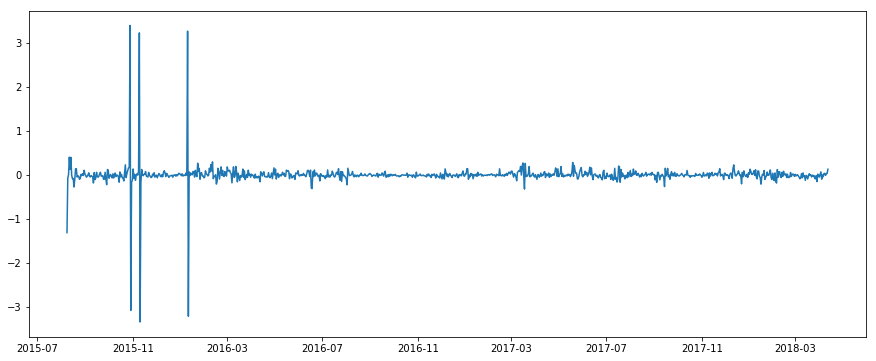

In [40]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
plt.plot(ts_log_diff)

/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


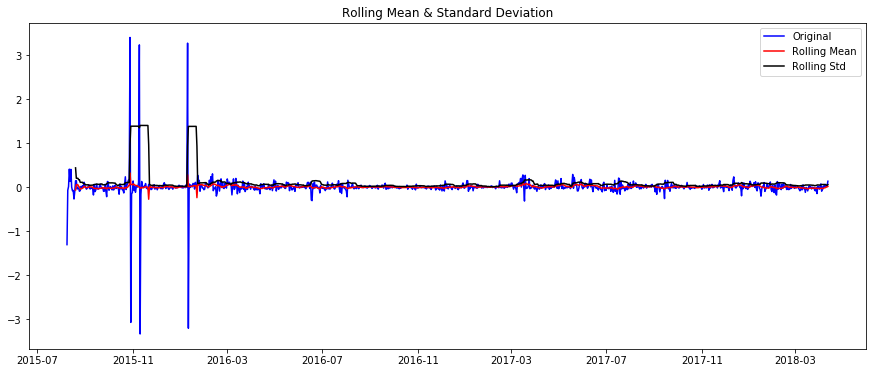

Results of Dickey-Fuller Test:
Test Statistic                -9.404876e+00
p-value                        6.049069e-16
#Lags Used                     1.200000e+01
Number of Observations Used    9.660000e+02
Critical Value (5%)           -2.864537e+00
Critical Value (1%)           -3.437138e+00
Critical Value (10%)          -2.568366e+00
dtype: float64


In [41]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Decomposing

/home/cloudera/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


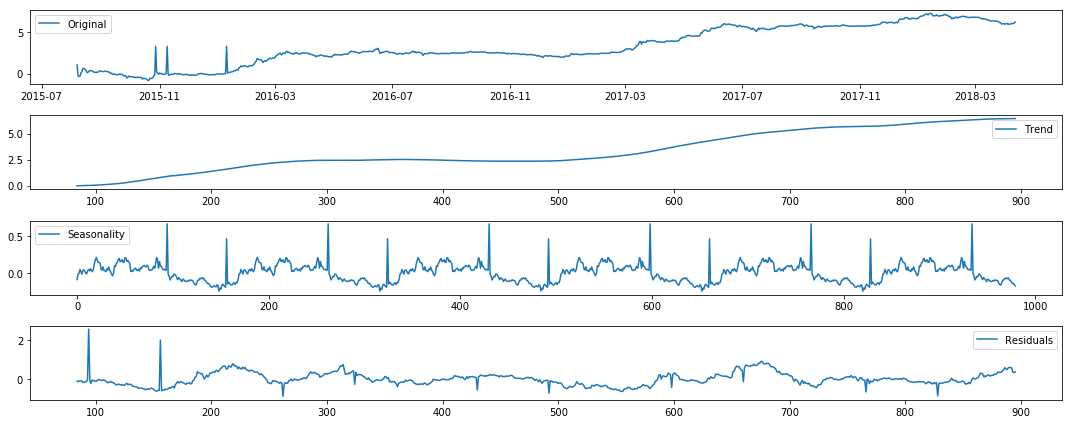

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_log.dropna(inplace=True)
decomposition = seasonal_decompose(ts_log.values, freq=168)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


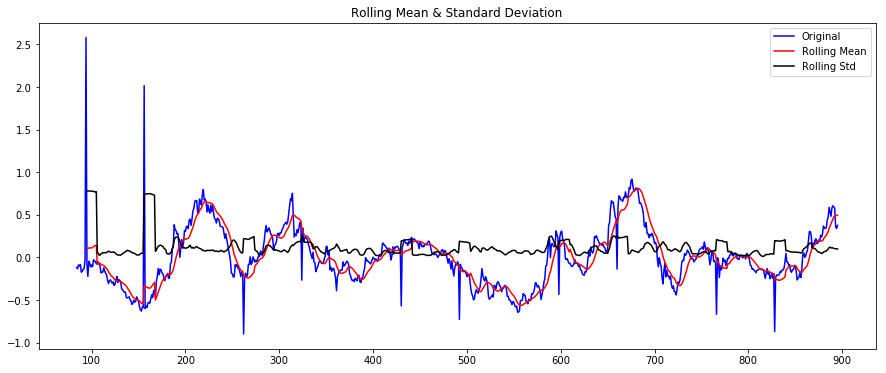

Results of Dickey-Fuller Test:
Test Statistic                  -3.538571
p-value                          0.007050
#Lags Used                       4.000000
Number of Observations Used    807.000000
Critical Value (5%)             -2.865128
Critical Value (1%)             -3.438479
Critical Value (10%)            -2.568681
dtype: float64


In [43]:
ts_log_decompose = pd.DataFrame(residual)
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose.iloc[:,0])

## Forecasting 

In [44]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [45]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

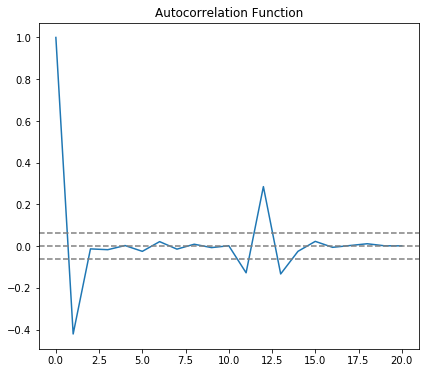

In [46]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

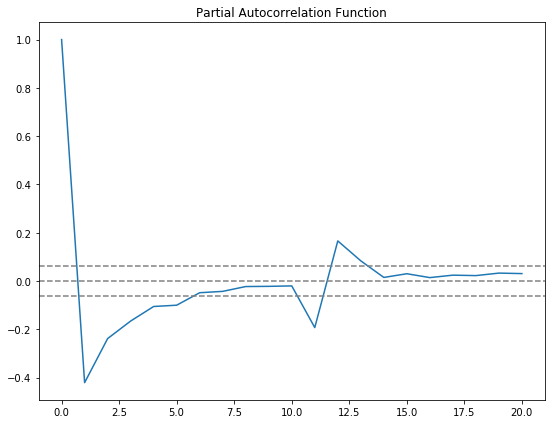

In [47]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [48]:
from statsmodels.tsa.arima_model import ARIMA

### AR Model

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  979
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  -3.097
Method:                       css-mle   S.D. of innovations              0.243
Date:                Sun, 22 Apr 2018   AIC                             12.194
Time:                        14:14:32   BIC                             26.854
Sample:                    08-08-2015   HQIC                            17.772
                         - 04-12-2018                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.0057      0.005      1.043      0.297        -0.005     0.016
ar.L1.D.close    -0.4308      0.029    -14.724      0.000        -0.488    -0.373
                                    Root

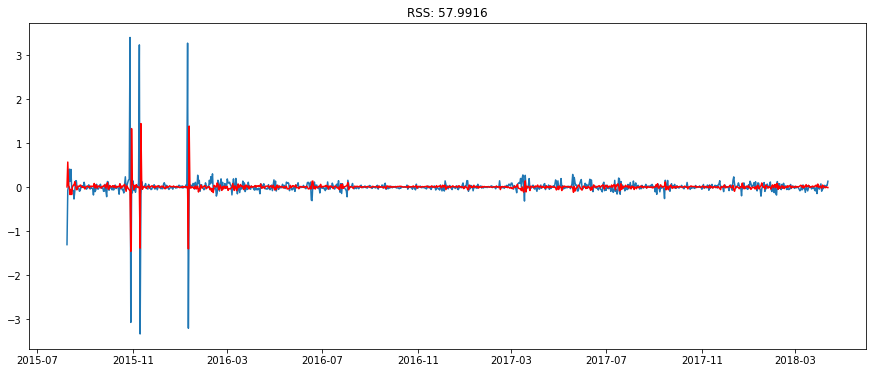

In [49]:
model = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
print results_AR.summary()
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### MA Model

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  979
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  52.324
Method:                       css-mle   S.D. of innovations              0.229
Date:                Sun, 22 Apr 2018   AIC                            -98.649
Time:                        14:14:36   BIC                            -83.989
Sample:                    08-08-2015   HQIC                           -93.071
                         - 04-12-2018                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.0060      0.003      2.313      0.021         0.001     0.011
ma.L1.D.close    -0.6484      0.026    -25.085      0.000        -0.699    -0.598
                                    Root

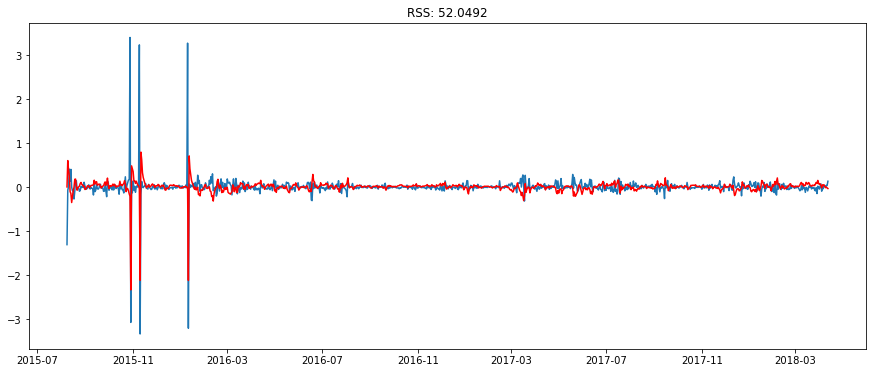

In [50]:
model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
print results_MA.summary()

### Combined Model

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  979
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  53.515
Method:                       css-mle   S.D. of innovations              0.229
Date:                Sun, 22 Apr 2018   AIC                            -99.030
Time:                        14:14:42   BIC                            -79.484
Sample:                    08-08-2015   HQIC                           -91.593
                         - 04-12-2018                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.0060      0.002      2.436      0.015         0.001     0.011
ar.L1.D.close     0.0761      0.049      1.560      0.119        -0.019     0.172
ma.L1.D.close    -0.6917      0.034    -

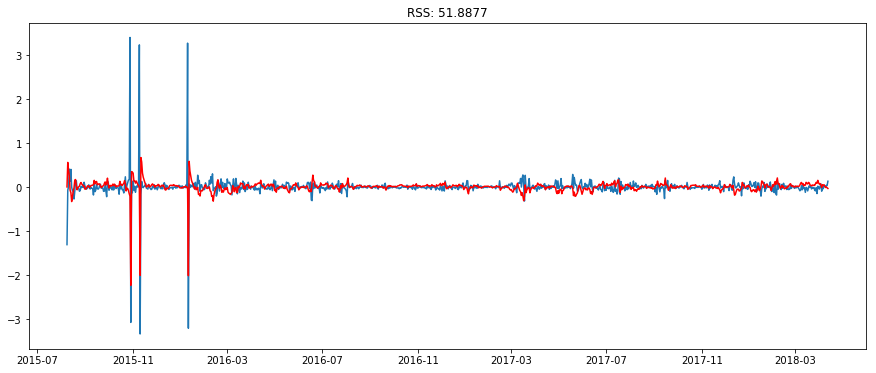

In [51]:
model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
print results_ARIMA.summary()
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

### Taking it back to original scale

In [52]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

date
2015-08-08    0.005656
2015-08-09    0.570942
2015-08-10    0.037815
2015-08-11    0.001982
2015-08-12   -0.168598
dtype: float64


In [53]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

date
2015-08-08    0.005656
2015-08-09    0.576599
2015-08-10    0.614414
2015-08-11    0.616396
2015-08-12    0.447798
dtype: float64


In [54]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date
2015-08-07    1.018847
2015-08-08    1.024504
2015-08-09    1.595446
2015-08-10    1.633261
2015-08-11    1.635243
dtype: float64

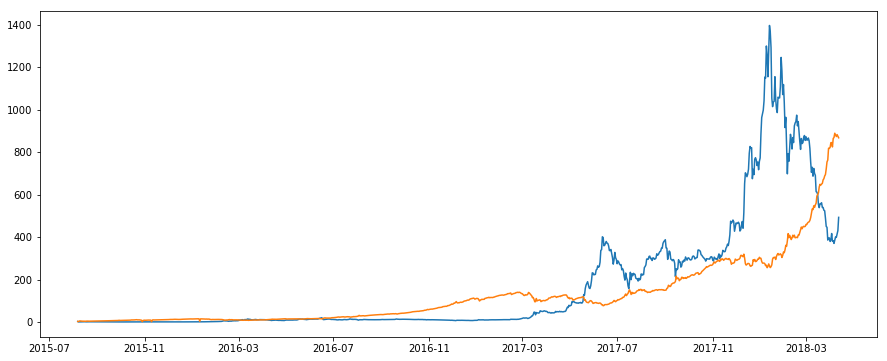

In [55]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)


### Prediction Evaluation

[1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 

(array([ 488.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  492.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

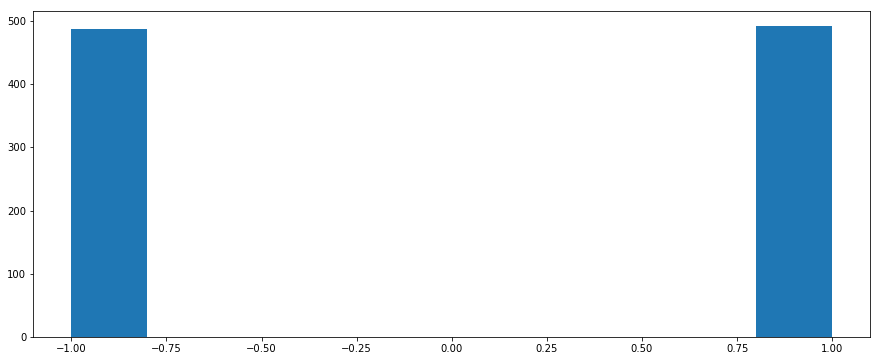

In [56]:
#increase or decrease prediction
btc_tgt = ts

btc_diff=[]
btc_diff.append(1)
for i in xrange(1,len(btc_tgt)):
    v = btc_tgt.iloc[i] - btc_tgt.iloc[i-1]
    if v < 0:
        btc_diff.append(-1)
    else:
        btc_diff.append(1)

print(btc_diff)
print(len(btc_diff))

plt.hist(btc_diff)
plt.show()

[1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1,

(array([ 335.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  645.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

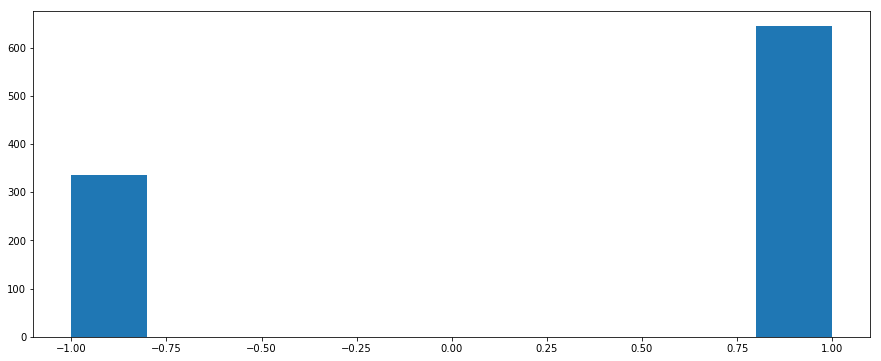

In [57]:
btc_pred = predictions_ARIMA

btc_dpred=[]
btc_dpred.append(1)
for i in xrange(1,len(btc_pred)):
    v = btc_pred.iloc[i] - btc_pred.iloc[i-1]
    if v < 0:
        btc_dpred.append(-1)
    else:
        btc_dpred.append(1)

print(btc_dpred)
print(len(btc_dpred))

plt.hist(btc_dpred)
plt.show()

[[172 316]
 [163 329]]
0.511224489796
0.510579101693
0.5117551776
0.498349454075


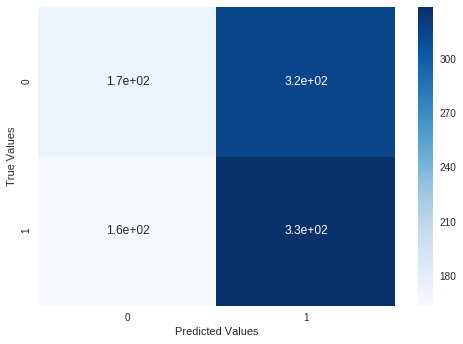

precision: [ 0.51343284  0.51007752]
recall: [ 0.35245902  0.66869919]
fscore: [ 0.41798299  0.57871592]
support: [488 492]


In [58]:
#Checking Accuracy and other metrics
from sklearn import metrics
import seaborn as sns

#Evaluation Metrics
#Confusion Matrix, accuracy, recall, precision and f1-score
print(metrics.confusion_matrix(btc_diff, btc_dpred))
print(metrics.accuracy_score(btc_diff, btc_dpred))
print(metrics.recall_score(btc_diff, btc_dpred,average='macro'))
print(metrics.precision_score(btc_diff, btc_dpred,average='macro'))
print(metrics.f1_score(btc_diff, btc_dpred,average='macro'))

ht = sns.heatmap(pd.DataFrame(metrics.confusion_matrix(btc_diff, btc_dpred)), annot=True, cmap="Blues")
ht.set(xlabel='Predicted Values', ylabel='True Values')
plt.show()

#Another way to view these metrics for every class label
precision, recall, fscore, support = metrics.precision_recall_fscore_support(btc_diff, btc_dpred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))